# Plots for Abstention Loss for Regression
author: Elizabeth A. Barnes, Randal J. Barnes

version = v1.8

date: March 21, 2021


In [1]:
import numpy as np
import time
import sys
import collections
import os
import glob
import pickle

import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras import optimizers
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy as ct
import cartopy.crs as ccrs
import seaborn as sns

import abstentionloss as abstentionloss
import metrics as metrics
import network as network
import plots as plots
import climatedata as climatedata
import experiments as experiments
import twoDdata as twoDdata

from sklearn.metrics import mean_absolute_error
import pandas as pd
from scipy import stats, special
  
import imp
imp.reload(experiments)
imp.reload(abstentionloss)
imp.reload(plots)
imp.reload(climatedata)
imp.reload(twoDdata)

import palettable
import pprint

mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi']= 150
dpiFig = 800.

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
tf.print(f"sys.version = {sys.version}", output_stream=sys.stdout)
tf.print(f"tf.version.VERSION = {tf.version.VERSION}", output_stream=sys.stdout)

sys.version = 3.7.9 (default, Aug 31 2020, 07:22:35) 
[Clang 10.0.0 ]
tf.version.VERSION = 2.4.1


In [2]:
# EXP_NAME = 'tranquilFOOr22'
# EXP_NAME = 'tranquilFOOr16'
# EXP_NAME = 'tranquilFOOr45'
# EXP_NAME = 'corruptInputsr22'
# # EXP_NAME = 'corruptInputsr25'
EXP_NAME = 'olsr1'

EXPINFO = experiments.define_experiments(EXP_NAME)
pprint.pprint(EXPINFO, width=60)
#--------------------------------------------------------
FINAL_FIGS_LIST = ('olsr1',
                   'tranquilFOOr22',
                   'tranquilFOOr16',                   
                   'tranquilFOOr45',
                   'corruptInputsr22',                   
                  )

{'act_fun': 'relu',
 'batch_size': 32,
 'boxcox': False,
 'coarse_setpoint': 0.1,
 'exp_name': 'olsr1',
 'fixed_alpha': 0.1,
 'hiddens': [5, 5],
 'loss': 'AbstentionLogLoss',
 'lr_init': 0.0001,
 'n_coarse_epochs': 0,
 'n_epochs': 1000,
 'n_samples': [4000, 1000],
 'n_spinup_epochs': 225,
 'noise': [0.5, 0.05],
 'np_seed': 99,
 'numClasses': 2,
 'nupd': nan,
 'patience': 200,
 'ridge_param': 0.0,
 'slope': [1.0, 0.7],
 'spinup': 0,
 'undersample': False,
 'updater': 'Constant',
 'x_sigma': [0.25, 0.5],
 'yint': [-2.0, 0.6]}


In [3]:
NP_SEED = 99
np.random.seed(NP_SEED)
tf.random.set_seed(99)

## Internal functions

In [4]:
def get_long_name(exp_name, loss_str, setpoint, network_seed, np_seed):
    # set experiment name
    LONG_NAME = (
        exp_name
        + '_' + loss_str            
        + '_setpoint' + str(setpoint)
        + '_networkSeed' + str(network_seed)
        + '_npSeed' + str(np_seed)
    )

    return LONG_NAME

## Load the data


noise fraction = 80.0%
training samples shapes = (3000,)
validation samples shapes = (1000,)
testing samples shapes = (1000,)
not actually standardizing the data



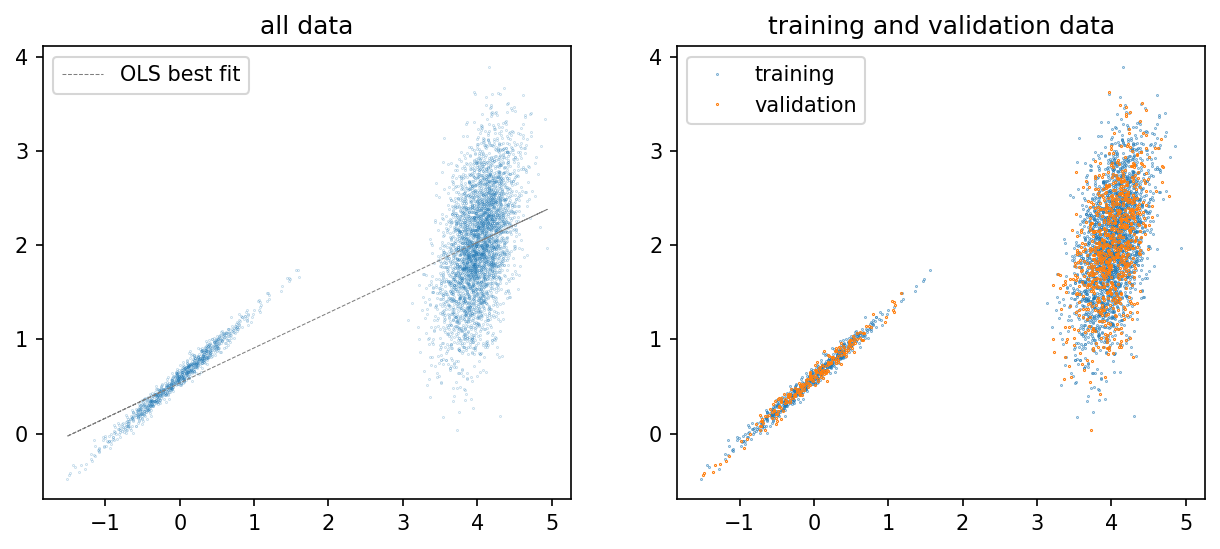

In [5]:
np.random.seed(NP_SEED)
imp.reload(experiments)
imp.reload(twoDdata)
EXPINFO = experiments.define_experiments(EXP_NAME)

if EXP_NAME.find('olsr')==0:
    imp.reload(twoDdata)
    X_train_std, onehot_train, X_val_std, onehot_val, X_test_std, onehot_test, xmean, xstd, tr_train, tr_val, tr_test = twoDdata.get_data(EXPINFO,to_plot=True)
else:
    imp.reload(climatedata)
    X_train_std, onehot_train, X_val_std, onehot_val, X_test_std, onehot_test, xmean, xstd, tr_train, tr_val, tr_test = climatedata.get_climate_data(EXPINFO)


# Get the statistics

In [6]:
def compute_error(y_pred,y_true,stat='mean'):
    try:
        e = np.abs(y_pred-y_true)
        if(stat=='mean'):
            err = np.mean(e)
        elif(stat=='median'):
            err = np.median(e)
        else:
            raise ValueError('no such stat')
    except:
        err = np.nan
    return err

def compute_loglikelihood(y_pred,y_true,stat='mean'):
    try:
        p = -stats.norm.logpdf(x=y_true,loc=y_pred[:,0],scale=y_pred[:,1])
        
        if(stat=='mean'):
            like = np.mean(p)
        elif(stat=='median'):
            print('the median is not a good choice for the loglikelihood')
            like = np.median(p)
        else:
            raise ValueError('no such stat')        
    except:
        like = np.nan
    return like

def compute_likelihood(y_pred,y_true,stat='mean'):
    try:
        p = stats.norm.pdf(x=y_true,loc=y_pred[:,0],scale=y_pred[:,1])
        
        if(stat=='mean'):
            like = np.mean(p)
        elif(stat=='median'):
            like = np.median(p)
        else:
            raise ValueError('no such stat')        
    except:
        like = np.nan
    return like

In [7]:
def get_tau_vector(model,X):
    y_pred = model.predict(X)

    tau_dict = {}
    for perc in np.around(np.arange(0.,1.1,.1),3):
        tau_dict[perc] =  np.percentile(y_pred[:,-1],100-perc*100.)
    
    return tau_dict

In [8]:
imp.reload(abstentionloss)
imp.reload(metrics)
imp.reload(experiments)
imp.reload(plots)

#---------------------
EXPINFO = experiments.define_experiments(EXP_NAME)
ACT_FUN = EXPINFO['act_fun']
hiddens = EXPINFO['hiddens']
NUM_CLASSES = EXPINFO['numClasses']
RIDGE = 0.
STAT = 'mean'

model_spinup = network.defineNN(hiddens, 
                             input_shape=X_train_std.shape[1], 
                             output_shape=NUM_CLASSES, 
                             ridge_penalty=RIDGE, 
                             act_fun=ACT_FUN, 
                             network_seed=99)

ANN_model = network.defineNN(hiddens, 
                             input_shape=X_train_std.shape[1], 
                             output_shape=NUM_CLASSES, 
                             ridge_penalty=RIDGE, 
                             act_fun=ACT_FUN, 
                             network_seed=99)

In [9]:
setpoint_vector = np.around(np.arange(0.1,1.,.1),3)
cov_frac_vec =  np.around(np.arange(0.05,1.05,.05),3)   
cov_frac_vec = np.insert(cov_frac_vec,0,.01)

data_matrix = np.zeros((len(cov_frac_vec),len(setpoint_vector)))
df = pd.DataFrame(columns=('network_seed',
                           'setpoint',
                           'cov_frac',
                           'diff',
                           'total_cov_perc',
                           'mae',
                           'type',
                           'err_mean',
                           'err_std',
                           'err_mean_train',
                           'err_std_train',
                           'likelihood',
                           'loglikelihood'))

NETWORK_SEED_LIST = np.arange(0,30)
SETPOINT_LIST = np.around(np.arange(0.,1.,.1),3)

for isetpoint, setpoint in enumerate(SETPOINT_LIST):
    print(setpoint)
    for network_seed in NETWORK_SEED_LIST:
        #---------------------------------------
        RUN_LOSS = EXPINFO['loss']
        LONG_NAME = get_long_name(EXP_NAME, RUN_LOSS, setpoint, network_seed, NP_SEED)
        model_file = 'saved_models/model_' +  LONG_NAME + '.h5'
        if(os.path.exists(model_file)==False):
            continue
            
        #-------------------------------
        # load the baseline spin-up model
        if(setpoint>0):
            spinup_file = 'saved_models/model_' +  get_long_name(exp_name=EXP_NAME, 
                                                                 loss_str='RegressLogLoss', 
                                                                 setpoint=-1., 
                                                                 network_seed=network_seed, 
                                                                 np_seed=NP_SEED)
            model_spinup.load_weights(spinup_file + '.h5')
            tau_dict = get_tau_vector(model_spinup,X_val_std)
            if(EXPINFO['updater']=='Constant'):
                print('---- setting tau = coarse_tau ----')
                TAU = tau_dict[EXPINFO['coarse_setpoint']]
            else:
                TAU = tau_dict[setpoint]   
            print('  tau = ' + str(TAU))

        ANN_model.load_weights(model_file)
        y_pred = ANN_model.predict(X_test_std)
        i_noabstain = np.where(y_pred[:,-1]<=TAU)[0]
        i_abstain = np.where(y_pred[:,-1]>TAU)[0]
        tau_frac_dac = len(i_noabstain)/len(y_pred[:,-1])
        dac_err = compute_error(y_pred[i_noabstain,0],onehot_test[i_noabstain,0],STAT)
        dac_lik = compute_likelihood(y_pred[i_noabstain,:],onehot_test[i_noabstain,0],STAT)
        dac_loglik = compute_loglikelihood(y_pred[i_noabstain,:],onehot_test[i_noabstain,0],STAT)      
    
        # testing error
        err = (y_pred[i_noabstain,0] - onehot_test[i_noabstain,0])/y_pred[i_noabstain,1]
        err_mean = np.mean(err)
        err_std = np.std(err)    

        if((setpoint==.2 or EXPINFO['updater']=='Constant') and network_seed==0):
            i_noabstain_low = np.copy(i_noabstain)
            i_abstain_low = np.copy(i_abstain)
            y_pred_test_abstain_low = np.copy(y_pred[:,:])
            y_true_test_abstain_low = np.copy(onehot_test[:,0])
            err_test_abstain_low = np.copy(err)

        if((setpoint==.8 or EXPINFO['updater']=='Constant') and network_seed==0):
            i_noabstain_high = np.copy(i_noabstain)            
            i_abstain_high = np.copy(i_abstain)                       
            y_pred_test_abstain_high = np.copy(y_pred[:,:])
            y_true_test_abstain_high = np.copy(onehot_test[:,0])
            err_test_abstain_high = np.copy(err)
            
        # training error
        y_pred = ANN_model.predict(X_train_std)
        i_noabstain = np.where(y_pred[:,-1]<=TAU)[0]        
        err = (y_pred[i_noabstain,0] - onehot_train[i_noabstain,0])/y_pred[i_noabstain,1]
        err_mean_train = np.mean(err)
        err_std_train = np.std(err)    
        
        
        #------------------------------------------------------------------
        # fill data frame
        df1 = {'network_seed': network_seed,
               'setpoint': setpoint,
               'cov_frac': np.round(tau_frac_dac*100),
               'mae': dac_err,
               'likelihood': dac_lik,                  
               'loglikelihood': dac_loglik,                                 
               'type': 'dac',
               'err_mean': err_mean,
               'err_std': err_std,                 
               'err_mean_train': err_mean_train,
               'err_std_train': err_std_train,                 
               'total_cov_perc':np.round(tau_frac_dac*100)}
        df = df.append(df1,ignore_index = True)                 

print('running DNN computations now...')        
for network_seed in NETWORK_SEED_LIST:
    for cov_frac in cov_frac_vec:

        #---------------------------------------
        RUN_LOSS = 'RegressLogLoss'
        LONG_NAME = get_long_name(EXP_NAME, RUN_LOSS, setpoint = 0., network_seed = network_seed, np_seed = NP_SEED)
        model_file = 'saved_models/model_' +  LONG_NAME + '.h5'
        if(os.path.exists(model_file)==False):
            continue

        ANN_model.load_weights(model_file)
        y_pred = ANN_model.predict(X_test_std)
        sigma_cutoff = np.percentile(y_pred[:,1],100*cov_frac)
        i_noabstain = np.where(y_pred[:,1]<=sigma_cutoff)[0]       
        tau_frac_dnn = len(i_noabstain)/len(y_pred[:,-1])
        dnn_err = compute_error(y_pred[i_noabstain,0],onehot_test[i_noabstain,0],STAT)
        dnn_lik = compute_likelihood(y_pred[i_noabstain,:],onehot_test[i_noabstain,0],STAT)
        dnn_loglik = compute_loglikelihood(y_pred[i_noabstain,:],onehot_test[i_noabstain,0],STAT)    
        
        # testing error
        err = (y_pred[i_noabstain,0] - onehot_test[i_noabstain,0])/y_pred[i_noabstain,1]
        err_mean = np.mean(err)
        err_std = np.std(err)    
        if(cov_frac==1.0 and network_seed==0):
            y_pred_test = np.copy(y_pred[i_noabstain,:])
            y_true_test = np.copy(onehot_test[i_noabstain,0])
            err_test = np.copy(err)

        
        # training error
        y_pred = ANN_model.predict(X_train_std)
        sigma_cutoff = np.percentile(y_pred[:,1],100*cov_frac)
        i_noabstain = np.where(y_pred[:,1]<=sigma_cutoff)[0]       
        err = (y_pred[i_noabstain,0] - onehot_train[i_noabstain,0])/y_pred[i_noabstain,1]
        err_mean_train = np.mean(err)
        err_std_train = np.std(err)        
        if(cov_frac==1.0 and network_seed==0):
            y_pred_train = np.copy(y_pred[i_noabstain,:])
            y_true_train = np.copy(onehot_train[i_noabstain,0])
            err_train = np.copy(err)
        
        #------------------------------------------------------------------
        # fill data frame
        df1 = {'network_seed': network_seed,
               'setpoint': 1.-cov_frac,
               'cov_frac': np.round(cov_frac*100),
               'mae': dnn_err,
               'likelihood': dnn_lik,
               'loglikelihood': dnn_loglik,               
               'type': 'dnn',
               'err_mean': err_mean,
               'err_std': err_std,                 
               'err_mean_train': err_mean_train,
               'err_std_train': err_std_train,                                
               'total_cov_perc':np.round(cov_frac*100)}
        df = df.append(df1,ignore_index = True) 
print('done.')
        
plt.show()        

0.0
0.1
---- setting tau = coarse_tau ----
  tau = 0.5769451916217805
---- setting tau = coarse_tau ----
  tau = 0.5605483949184418
---- setting tau = coarse_tau ----
  tau = 0.773695707321167


/Users/eabarnes/opt/anaconda3/envs/env-tf2.4/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/eabarnes/opt/anaconda3/envs/env-tf2.4/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/eabarnes/opt/anaconda3/envs/env-tf2.4/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/eabarnes/opt/anaconda3/envs/env-tf2.4/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/eabarnes/opt/anaconda3/envs/env-tf2.4/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
running DNN computations now...
done.


In [10]:
standard_err = []

for network_seed in np.arange(0,50):

    LONG_NAME = get_long_name(EXP_NAME, 'StandardMAE', -2.0, network_seed, NP_SEED)
    model_file = 'saved_models/model_' +  LONG_NAME + '.h5'
    try:
        ANN_model.load_weights(model_file)
        y_pred = ANN_model.predict(X_test_std)
        e = compute_error(y_pred[:,0],onehot_test[:,0],STAT)
        standard_err.append(e)
    except:
        if(np.size(standard_err)==0):
            standard_err = [np.nan, np.nan]            
        continue
    
print(standard_err)
standard_err = [np.min(standard_err)]
print(standard_err)

[0.3768166244626268, 0.37290223227952174, 0.6286594114912286]
[0.37290223227952174]


# Prediction summary plots (lines + dots)

In [1]:
### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([]) 
################################  
################################           
fig = plt.figure()
ax = plt.subplot(111)
################################  
################################  
adjust_spines(ax, ['left', 'bottom'])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
################################  
################################  
ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)
################################  
################################
df_plot = df

# DAC
x_var = 'total_cov_perc'#'setpoint'
sns.scatterplot(x=x_var,
                y='mae',
                data=df_plot[df_plot['type']=='dac'],
                s=15,
                legend=False,
                label='CAN-regression',
                hue='setpoint',
                edgecolor='black',
                palette = palettable.cartocolors.qualitative.Vivid_5.mpl_colormap,)

# DNN
df_stats = df_plot[df_plot['type']=='dnn'].groupby([x_var]).describe()
var = 'mae'
plt.fill_between(x=df_stats.index, 
                 y1=df_stats[(var, 'min')], 
                 y2=df_stats[(var, 'max')], 
                 alpha = .2,
                 label='Baseline ANN',
                 color='mediumpurple',
                )


ax9 = sns.lineplot(data=df_plot[df_plot['type']=='dnn'], x=x_var, y='mae', 
                  label = None, 
                  legend = None,
                  ci = None, 
                  estimator = np.median, 
                  markers=False,
                  color = 'mediumpurple',
                  dashes=[(2,2)],
                  linewidth=1.5,
                  alpha = .3,
              )

if np.isnan(standard_err[0])==False:
    for i in np.arange(0,len(standard_err)):
        if(i==0):
            label = 'standard MAE model'
        else:
            label = None
        plt.axhline(y=standard_err[i],linestyle='--',label=label,color='indigo',alpha=.25)
    try:
        legend_labelhandles, legend_labels = ax.get_legend_handles_labels()    
        legend_labelhandles = [legend_labelhandles[i] for i in (0,2,1)]
        legend_labels = [legend_labels[i] for i in (0,2,1)]
    except:
        print('legend swap did not work')
else:
    legend_labelhandles, legend_labels = ax.get_legend_handles_labels()    
    legend_labelhandles = [legend_labelhandles[i] for i in (1,0)]
    legend_labels = [legend_labels[i] for i in (1,0)]
    

################################  
################################
# file name 
RUN_LOSS = EXPINFO['loss']
LONG_NAME = get_long_name(EXP_NAME, RUN_LOSS, setpoint=0.9, network_seed=network_seed, np_seed = NP_SEED)
LONG_NAME = LONG_NAME.replace('_setpoint0.9','').replace(('_networkSeed' + str(network_seed)),'')
#----------------------------------
FS = 16

array_of_xlabels = np.round(np.arange(0,110,10),3)
array_of_ylabels = np.round(np.arange(0,.9,.1),3)
plt.xticks(array_of_xlabels,map(str,array_of_xlabels))
plt.yticks(array_of_ylabels,map(str,array_of_ylabels))
plt.ylabel('mean absolute error', fontsize=FS)
plt.xlabel('coverage (\%)', fontsize=FS)
plt.text(.01,.87,'worse', fontfamily='monospace', fontsize='small', va='center',ha='left',transform=ax9.transAxes,color='dimgrey') 
plt.text(.01,.03,'better', fontfamily='monospace', fontsize='small', va='center',ha='left',transform=ax9.transAxes,color='dimgrey') 
plt.xlim(-1,101)
plt.ylim(0.,.89)
plt.legend(legend_labelhandles,
           legend_labels,
           fontsize=7,
           loc="upper center",
           bbox_to_anchor=(.5, 1.01),
           ncol=3,
           frameon=False)
if(EXP_NAME=='tranquilFOOr45' or EXP_NAME=='corruptInputsr22'):
    plt.title('(c) Error by percent coverage', fontsize=FS, color='k')
else:
    plt.title('(d) Error by percent coverage', fontsize=FS, color='k')
plt.gca().invert_xaxis()
plt.tight_layout()
plt.savefig('figures/summary_plots/' + STAT + '_absoluteError_line_dots_' + LONG_NAME + '.png', dpi=dpiFig)
if(EXP_NAME in FINAL_FIGS_LIST):
    plt.savefig('figures/final_figures/' + STAT + '_absoluteError_line_dots_' + LONG_NAME + '.png', dpi=dpiFig)    
plt.show()

NameError: name 'plt' is not defined

In [12]:
raise ValueError('here')

ValueError: here

# Uncertainty plots

In [ ]:
#---- look at errors ----
bins = np.arange(-6,6,.25)

ax=plt.subplot(1,1,1)
#-----------------
# training data
sns.histplot(err_train, 
             bins=bins, 
             kde=True, 
             stat='probability',
             fill=True,
             color='tab:blue',
             edgecolor='white',
             line_kws={'linewidth':2.},             
             label='training data')
text = 'mean = ' + str(np.round(np.mean(err_train),2)) + '\nstd dev. = ' + str(np.round(np.std(err_train),2))
plt.text(0.62, 0.55, text, fontfamily='monospace', fontsize='small', va='top',ha='left',transform=ax.transAxes,color='tab:blue')

#-----------------
# testing data
sns.histplot(err_test, 
             bins=bins, 
             kde=True, 
             stat='probability',
             fill=True,
             color='tab:orange',
             edgecolor='white',
             alpha = .5,
             line_kws={'linewidth':2.},
             label='testing data')
text = 'mean = ' + str(np.round(np.mean(err_test),2)) + '\nstd dev. = ' + str(np.round(np.std(err_test),2))
plt.text(0.33, 0.3, text, fontfamily='monospace', fontsize='small', va='top',ha='right',transform=ax.transAxes,color='tab:orange',alpha=.75)


plt.xlim(-6,6)
plt.xlabel('standardized error (z)',fontsize=FS)
plt.ylabel('probability',fontsize=FS)

plt.legend(
           fontsize=7,
           loc="upper right",
           bbox_to_anchor=(1.0, 1.01),
           ncol=1,
           frameon=False)

# plt.title('Error distributions are well behaved',fontsize=FS)
array_of_xlabels = np.arange(-6,8,2)
array_of_ylabels = np.round(np.arange(0,.12,.02),3)
plt.xticks(array_of_xlabels,map(str,array_of_xlabels))
plt.yticks(array_of_ylabels,map(str,array_of_ylabels))

ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)


plt.tight_layout()
plt.savefig('figures/error_plots/histograms_' + LONG_NAME + '_networkSeed0.png', dpi=dpiFig)
if(EXP_NAME in FINAL_FIGS_LIST):
    plt.savefig('figures/final_figures/histograms_' + LONG_NAME + '_networkSeed0.png', dpi=dpiFig)

plt.show()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cm = plt.cm.get_cmap('Spectral_r')
bins = np.arange(0,4.1,.05)

da = df[df['network_seed']==0]

if LONG_NAME.find('olsr')!=0:

    bounds = 7.
    #--------------------------
    fig=plt.figure(figsize=(5*3*.75,5*.75))
    #---------------
    # baseline DNN
    ax1 = plt.subplot(1,3,1)
    plt.plot((-bounds,bounds),(-bounds,bounds),'--',color='tab:gray',linewidth=1.,alpha=.5)
    sns.scatterplot(x=y_true_test, 
                    y=y_pred_test[:,0], 
                    hue=y_pred_test[:,1],
                    hue_norm=(0,2.),
    #                 hue_order=[0,.25,.5,.75,1.0,2.0,3.0],
                    s=8, 
                    legend=True,
                    alpha=.75,
                    palette='Spectral_r')

    plt.legend(
               fontsize=7,
               loc="upper left",
               bbox_to_anchor=(.0, 1.01),
               ncol=1,
               title='sigma',
               frameon=False)

    plt.ylabel('predicted y',fontsize=FS)
    plt.xlabel('true y',fontsize=FS)
    plt.xlim(-bounds,bounds)
    plt.ylim(-bounds,bounds)
    plt.title('(a) Baseline ANN Predictions\ncoverage = ' + str(int(100)) + '\%',fontsize=FS)  

    array_of_xlabels = np.arange(-bounds+1,bounds+1,2)
    plt.xticks(array_of_xlabels,map(str,array_of_xlabels))
    plt.yticks(array_of_xlabels,map(str,array_of_xlabels))

    # Create inset of width 1.3 inches and height 0.9 inches
    # at the default upper right location
    axins = inset_axes(ax1, 
                       width="100%", 
                       height="100%",
                       bbox_to_anchor=(.64, .15, .35, .25),
                       bbox_transform=ax1.transAxes,
                      )
    axins.axes.yaxis.set_visible(False)
#     sns.histplot(y_pred_test[:,1], bins=np.arange(0,3.1,.05),color='tab:gray')
    
    # non-abstained histograms
    data = y_pred_test[:,1]
    Y,X = np.histogram(data, bins)
    x_span = 2.
    C = [cm(((x-0.)/x_span)) for x in X]
    plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])   
    plt.xticks((0,1,2))    
    
    y_max = np.max(Y)*1.5
    
    plt.xlim(0,2.1)
    plt.ylim(0,y_max) 
    axins.spines['top'].set_color('none')
    axins.spines['right'].set_color('none')
    axins.spines['left'].set_color('none')
    axins.spines['bottom'].set_color('dimgrey')
    plt.text(0.125, 0.95, 'predicted\nsigma', fontfamily='monospace', fontsize='small', va='top',ha='left',transform=axins.transAxes,color='tab:blue',alpha=.75)

    ax1.spines['top'].set_color('none')
    ax1.spines['right'].set_color('none')
    ax1.spines['left'].set_color('dimgrey')
    ax1.spines['bottom'].set_color('dimgrey')
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)

    #---------------
    # abstention network = .2
    ax2 = plt.subplot(1,3,2)
    plt.plot((-bounds,bounds),(-bounds,bounds),'--',color='tab:gray',linewidth=1.,alpha=.5)
    sns.scatterplot(x=y_true_test_abstain_low[i_noabstain_low], 
                    y=y_pred_test_abstain_low[i_noabstain_low,0], 
                    hue=y_pred_test_abstain_low[i_noabstain_low,1],
                    hue_norm=(0,2.),
                    hue_order=[0,.25,.5,.75,1.0,2.0,3.0],
                    s=8, 
                    legend=False,
                    alpha=.75,
                    palette='Spectral_r')

    # plt.legend(
    #            fontsize=7,
    #            loc="upper left",
    #            bbox_to_anchor=(.0, 1.01),
    #            ncol=1,
    #            title='sigma',
    #            frameon=False)

    plt.ylabel('predicted y',fontsize=FS)
    plt.xlabel('true y',fontsize=FS)
    plt.xlim(-bounds,bounds)
    plt.ylim(-bounds,bounds)
    if(EXPINFO['updater']=='Constant'):
        plt.title('(b) CAN Predictions\ncoverage = ' + str(int(np.round(da[da['type']=='dac']['cov_frac'].values[0]))) + '\%',fontsize=FS)  
    else:
        plt.title('(b) CAN Predictions\ncoverage = ' + str(int(np.round(da[da['setpoint']==.2]['cov_frac'].values[0]))) + '\%',fontsize=FS)  
                
    array_of_xlabels = np.arange(-bounds+1,bounds+1,2)
    plt.xticks(array_of_xlabels,map(str,array_of_xlabels))
    plt.yticks(array_of_xlabels,map(str,array_of_xlabels))

    ax2.axes.yaxis.set_visible(False) 


    # Create inset of width 1.3 inches and height 0.9 inches
    # at the default upper right location
    axins = inset_axes(ax2, 
                       width="100%", 
                       height="100%",
                       bbox_to_anchor=(.64, .15, .35, .25),
                       bbox_transform=ax2.transAxes,
                      )
    axins.axes.yaxis.set_visible(False)
    
    # abstained histograms
    data = y_pred_test_abstain_low[i_abstain_low,1]
    Y,X = np.histogram(data, bins)
    plt.bar(X[:-1],Y,color='tab:gray',width=X[1]-X[0])
    
    # non-abstained histograms
    data = y_pred_test_abstain_low[i_noabstain_low,1]
    Y,X = np.histogram(data, bins)
    x_span = 2.
    C = [cm(((x-0.)/x_span)) for x in X]
    plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
    plt.xticks((0,1,2))    
    
    plt.xlim(0,2.1)
    plt.ylim(0,y_max)   
    axins.spines['top'].set_color('none')
    axins.spines['right'].set_color('none')
    axins.spines['left'].set_color('none')
    axins.spines['bottom'].set_color('dimgrey')
    plt.text(0.63, 0.6, 'abstained\nsigma', fontfamily='monospace', fontsize='small', va='top',ha='left',transform=axins.transAxes,color='tab:gray',alpha=.75)
    plt.text(0.125, 0.95, 'predicted\nsigma', fontfamily='monospace', fontsize='small', va='top',ha='left',transform=axins.transAxes,color='tab:blue',alpha=.75)
    if(EXP_NAME=='corruptInputsr23' or EXP_NAME=='corruptInputsr22'):
        plt.arrow(0.63,.15,.1,0,transform=axins.transAxes,color='tab:gray',length_includes_head=True,width=.012,overhang=.1,linewidth=.5,head_length=.05,head_width=.05)

    ax2.spines['top'].set_color('none')
    ax2.spines['right'].set_color('none')
    ax2.spines['left'].set_color('dimgrey')
    ax2.spines['bottom'].set_color('dimgrey')
    ax2.spines['left'].set_linewidth(2)
    ax2.spines['bottom'].set_linewidth(2)


    #---------------
    # abstention network = .8
    ax3 = plt.subplot(1,3,3)
    plt.plot((-bounds,bounds),(-bounds,bounds),'--',color='tab:gray',linewidth=1.,alpha=.5)
    sns.scatterplot(x=y_true_test_abstain_high[i_noabstain_high], 
                    y=y_pred_test_abstain_high[i_noabstain_high,0], 
                    hue=y_pred_test_abstain_high[i_noabstain_high,1],
                    hue_norm=(0,2.),
                    hue_order=[0,.25,.5,.75,1.0,2.0,3.0],
                    s=8, 
                    legend=False,
                    alpha=.75,
                    palette='Spectral_r')

    # plt.legend(
    #            fontsize=7,
    #            loc="upper left",
    #            bbox_to_anchor=(.0, 1.01),
    #            ncol=1,
    #            title='sigma',
    #            frameon=False)

    plt.ylabel('predicted y',fontsize=FS)
    plt.xlabel('true y',fontsize=FS)
    plt.xlim(-bounds,bounds)
    plt.ylim(-bounds,bounds)
    if(EXPINFO['updater']=='Constant'):
        plt.title('(c) CAN Predictions\ncoverage = ' + str(int(np.round(da[da['type']=='dac']['cov_frac'].values[0]))) + '\%',fontsize=FS)  
    else:
        plt.title('(c) CAN Predictions\ncoverage = ' + str(int(np.round(da[da['setpoint']==.8]['cov_frac'].values[0]))) + '\%',fontsize=FS)  
        
    array_of_xlabels = np.arange(-bounds+1,bounds+1,2)
    plt.xticks(array_of_xlabels,map(str,array_of_xlabels))
    plt.yticks(array_of_xlabels,map(str,array_of_xlabels))

    ax3.axes.yaxis.set_visible(False) 

    # Create inset of width 1.3 inches and height 0.9 inches
    # at the default upper right location
    axins = inset_axes(ax3, 
                       width="100%", 
                       height="100%",
                       bbox_to_anchor=(.64, .15, .35, .25),
                       bbox_transform=ax3.transAxes,
                      )
    axins.axes.yaxis.set_visible(False)

    # abstained histograms
    data = y_pred_test_abstain_high[i_abstain_high,1]
    Y,X = np.histogram(data, bins)
    plt.bar(X[:-1],Y,color='tab:gray',width=X[1]-X[0])
    plt.xticks((0,1,2))
    
    # non-abstained histograms
    data = y_pred_test_abstain_high[i_noabstain_high,1]
    Y,X = np.histogram(data, bins)
    x_span = 2.
    C = [cm(((x-0.)/x_span)) for x in X]
    plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
    if(np.max(Y)>y_max):
        raise ValueError('y limit is not big enough!!!')
    
    ax3.spines['top'].set_color('none')
    ax3.spines['right'].set_color('none')
    ax3.spines['left'].set_color('dimgrey')
    ax3.spines['bottom'].set_color('dimgrey')
    ax3.spines['left'].set_linewidth(2)
    ax3.spines['bottom'].set_linewidth(2)
    
    #-----------------------------
    plt.xlim(0,2.1)
    plt.ylim(0,y_max)
    axins.spines['top'].set_color('none')
    axins.spines['right'].set_color('none')
    axins.spines['left'].set_color('none')
    axins.spines['bottom'].set_color('dimgrey')
    plt.text(0.63, 0.6, 'abstained\nsigma', fontfamily='monospace', fontsize='small', va='top',ha='left',transform=axins.transAxes,color='tab:gray',alpha=.75)
    plt.text(0.125, 0.95, 'predicted\nsigma', fontfamily='monospace', fontsize='small', va='top',ha='left',transform=axins.transAxes,color='tab:blue',alpha=.75)
    if(EXP_NAME=='corruptInputsr23' or EXP_NAME=='corruptInputsr22' or EXP_NAME=='tranquilFOOr45'):
        fig.delaxes(ax3)
        fig.delaxes(axins)
    
    #-----------------
    plt.tight_layout()
    plt.savefig('figures/error_plots/scatter_truthpredict_' + LONG_NAME + '_networkSeed0.png', dpi=dpiFig/2,bbox_inches='tight')
    if(EXP_NAME in FINAL_FIGS_LIST):
        plt.savefig('figures/final_figures/scatter_truthpredict_' + LONG_NAME + '_networkSeed0.png', dpi=dpiFig/2,bbox_inches='tight')
    plt.show()

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cm = plt.cm.get_cmap('Spectral_r')
bins = np.arange(0,4.1,.05)
FS = 16

da = df[df['network_seed']==0]

if LONG_NAME.find('olsr')==0:

    bounds = 7.
    #--------------------------
    fig = plt.figure(figsize=(5*3*.75,5*.75))
    #---------------
    # actual 2D data
    ax1 = plt.subplot(1,3,1)
    sns.scatterplot(x=X_test_std.flatten(), 
                    y=y_true_test, 
#                     hue=y_pred_test[:,1],
#                     hue_norm=(0,2.),
    #                 hue_order=[0,.25,.5,.75,1.0,2.0,3.0],
                    s=8, 
                    legend=True,
                    alpha=.75,
                    color='black',
                    palette='Spectral_r')
    
#     plt.legend(
#                fontsize=7,
#                loc="upper left",
#                bbox_to_anchor=(.0, 1.01),
#                ncol=1,
#                title='sigma',
#                frameon=False)    

    plt.xlabel('x',fontsize=FS)
    plt.ylabel('y',fontsize=FS)
    plt.xlim(-bounds,bounds)
    plt.ylim(-bounds,bounds)
    plt.title('(a) Data',fontsize=FS)  

    array_of_xlabels = np.arange(-bounds+1,bounds+1,2)
    plt.xticks(array_of_xlabels,map(str,array_of_xlabels))
    plt.yticks(array_of_xlabels,map(str,array_of_xlabels))
    
    ax1.spines['top'].set_color('none')
    ax1.spines['right'].set_color('none')
    ax1.spines['left'].set_color('dimgrey')
    ax1.spines['bottom'].set_color('dimgrey')
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    
    
    #---------------    
    # baseline DNN
    ax1 = plt.subplot(1,3,2)
    plt.plot((-bounds,bounds),(-bounds,bounds),'--',color='tab:gray',linewidth=1.,alpha=.5)
    sns.scatterplot(x=y_true_test, 
                    y=y_pred_test[:,0], 
                    hue=y_pred_test[:,1],
                    hue_norm=(0,2.),
    #                 hue_order=[0,.25,.5,.75,1.0,2.0,3.0],
                    s=8, 
                    legend=True,
                    alpha=.75,
                    palette='Spectral_r')

    plt.legend(
               fontsize=7,
               loc="upper left",
               bbox_to_anchor=(.0, 1.01),
               ncol=1,
               title='sigma',
               frameon=False)

    plt.ylabel('predicted y',fontsize=FS)
    plt.xlabel('y',fontsize=FS)
    plt.xlim(-bounds,bounds)
    plt.ylim(-bounds,bounds)
    plt.title('(b) Baseline ANN Predictions\ncoverage = ' + str(int(100)) + '\%',fontsize=FS)  

    array_of_xlabels = np.arange(-bounds+1,bounds+1,2)
    plt.xticks(array_of_xlabels,map(str,array_of_xlabels))
    plt.yticks(array_of_xlabels,map(str,array_of_xlabels))

    # Create inset of width 1.3 inches and height 0.9 inches
    # at the default upper right location
    axins = inset_axes(ax1, 
                       width="100%", 
                       height="100%",
                       bbox_to_anchor=(.64, .15, .35, .25),
                       bbox_transform=ax1.transAxes,
                      )
    axins.axes.yaxis.set_visible(False)
#     sns.histplot(y_pred_test[:,1], bins=np.arange(0,3.1,.05),color='tab:gray')
    
    # non-abstained histograms
    data = y_pred_test[:,1]
    Y,X = np.histogram(data, bins)
    x_span = 2.
    C = [cm(((x-0.)/x_span)) for x in X]
    plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])    
    
    plt.xlim(0,2.1)
    plt.xticks((0,1,2))    
    plt.ylim(0,1000)    
    axins.spines['top'].set_color('none')
    axins.spines['right'].set_color('none')
    axins.spines['left'].set_color('none')
    axins.spines['bottom'].set_color('dimgrey')
    plt.text(-.1, 0.7, 'predicted\nsigma', fontfamily='monospace', fontsize='small', va='top',ha='left',transform=axins.transAxes,color='tab:blue',alpha=.75)

    ax1.spines['top'].set_color('none')
    ax1.spines['right'].set_color('none')
    ax1.spines['left'].set_color('dimgrey')
    ax1.spines['bottom'].set_color('dimgrey')
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    
    
    #---------------
    # abstention network = .8
    ax3 = plt.subplot(1,3,3)
    plt.plot((-bounds,bounds),(-bounds,bounds),'--',color='tab:gray',linewidth=1.,alpha=.5)
    sns.scatterplot(x=y_true_test_abstain_high[i_noabstain_high], 
                    y=y_pred_test_abstain_high[i_noabstain_high,0], 
                    hue=y_pred_test_abstain_high[i_noabstain_high,1],
                    hue_norm=(0,2.),
                    hue_order=[0,.25,.5,.75,1.0,2.0,3.0],
                    s=8, 
                    legend=False,
                    alpha=.75,
                    palette='Spectral_r')

    # plt.legend(
    #            fontsize=7,
    #            loc="upper left",
    #            bbox_to_anchor=(.0, 1.01),
    #            ncol=1,
    #            title='sigma',
    #            frameon=False)

    plt.ylabel('predicted y',fontsize=FS)
    plt.xlabel('y',fontsize=FS)
    plt.xlim(-bounds,bounds)
    plt.ylim(-bounds,bounds)
    if(EXPINFO['updater']=='Constant'):
        plt.title('(c) CAN Predictions\ncoverage = ' + str(int(np.round(da[da['type']=='dac']['cov_frac'].values[0]))) + '\%',fontsize=FS)  
    else:
        plt.title('(c) CAN Predictions\ncoverage = ' + str(int(np.round(da[da['setpoint']==.8]['cov_frac'].values[0]))) + '\%',fontsize=FS)  
        
    array_of_xlabels = np.arange(-bounds+1,bounds+1,2)
    plt.xticks(array_of_xlabels,map(str,array_of_xlabels))
    plt.yticks(array_of_xlabels,map(str,array_of_xlabels))

#     ax3.axes.yaxis.set_visible(False) 

    # Create inset of width 1.3 inches and height 0.9 inches
    # at the default upper right location
    axins = inset_axes(ax3, 
                       width="100%", 
                       height="100%",
                       bbox_to_anchor=(.64, .15, .35, .25),
                       bbox_transform=ax3.transAxes,
                      )
    axins.axes.yaxis.set_visible(False)

    # abstained histograms
    data = y_pred_test_abstain_high[i_abstain_high,1]
    Y,X = np.histogram(data, bins)
    plt.bar(X[:-1],Y,color='tab:gray',width=X[1]-X[0])
    
    # non-abstained histograms
    data = y_pred_test_abstain_high[i_noabstain_high,1]
    Y,X = np.histogram(data, bins)
    x_span = 2.
    C = [cm(((x-0.)/x_span)) for x in X]
    plt.bar(X[:-1],Y,color=C,width=X[1]-X[0])
    if(np.max(Y)>1000):
        raise ValueError('y limit is not big enough!!!')
    
    #-----------------------------
    plt.xlim(0,2.1)
    plt.xticks((0,1,2))
    plt.ylim(0,1000)
    axins.spines['top'].set_color('none')
    axins.spines['right'].set_color('none')
    axins.spines['left'].set_color('none')
    axins.spines['bottom'].set_color('dimgrey')
    plt.text(0.5, 0.5, 'abstained\nsigma', fontfamily='monospace', fontsize='small', va='top',ha='left',transform=axins.transAxes,color='tab:gray',alpha=.75)
    plt.text(-.1, 0.7, 'predicted\nsigma', fontfamily='monospace', fontsize='small', va='top',ha='left',transform=axins.transAxes,color='tab:blue',alpha=.75)
    
    ax3.spines['top'].set_color('none')
    ax3.spines['right'].set_color('none')
    ax3.spines['left'].set_color('dimgrey')
    ax3.spines['bottom'].set_color('dimgrey')
    ax3.spines['left'].set_linewidth(2)
    ax3.spines['bottom'].set_linewidth(2)
    
    #-----------------
    plt.tight_layout()
    plt.savefig('figures/error_plots/scatter_truthpredict_' + LONG_NAME + '_networkSeed0.png', dpi=dpiFig/2)
    if(EXP_NAME in FINAL_FIGS_LIST):
        plt.savefig('figures/final_figures/scatter_truthpredict_' + LONG_NAME + '_networkSeed0.png', dpi=dpiFig/2)
    plt.show()

## Blog post

In [30]:
i_abstain_high

array([  2,  14,  17,  23,  24,  35,  41,  44,  45,  48,  52,  60,  61,
        64,  68,  83,  88,  91,  92,  95,  97, 107, 112, 113, 122, 128,
       135, 139, 141, 146, 149, 170, 175, 177, 180, 191, 201, 215, 225,
       237, 250, 256, 260, 263, 264, 268, 270, 278, 279, 291, 295, 299,
       302, 307, 308, 322, 325, 328, 343, 344, 355, 362, 383, 392, 396,
       397, 399, 401, 411, 412, 415, 417, 426, 427, 428, 440, 448, 449,
       454, 461, 465, 469, 470, 471, 472, 481, 486, 494, 498, 499, 510,
       516, 517, 518, 522, 530, 532, 537, 538, 546, 551, 553, 563, 564,
       572, 573, 577, 578, 584, 588, 590, 595, 601, 608, 615, 620, 621,
       624, 638, 649, 652, 659, 663, 666, 668, 677, 678, 683, 684, 689,
       692, 694, 701, 703, 708, 710, 713, 719, 727, 729, 733, 755, 756,
       759, 766, 769, 774, 775, 779, 786, 791, 794, 801, 804, 811, 816,
       822, 823, 832, 839, 845, 847, 854, 855, 860, 881, 883, 885, 888,
       889, 896, 910, 913, 920, 921, 925, 929, 932, 938, 939, 94

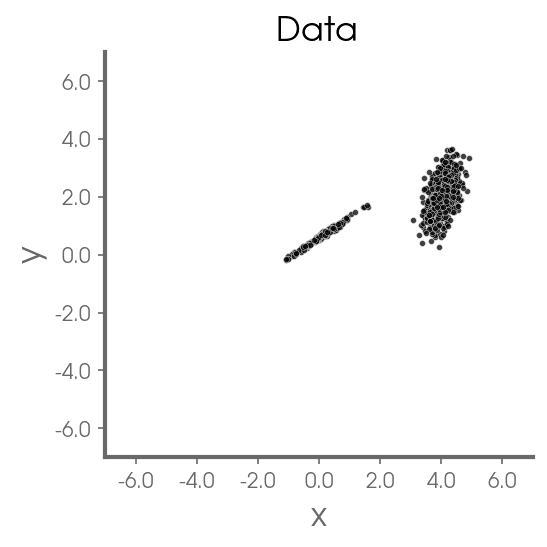

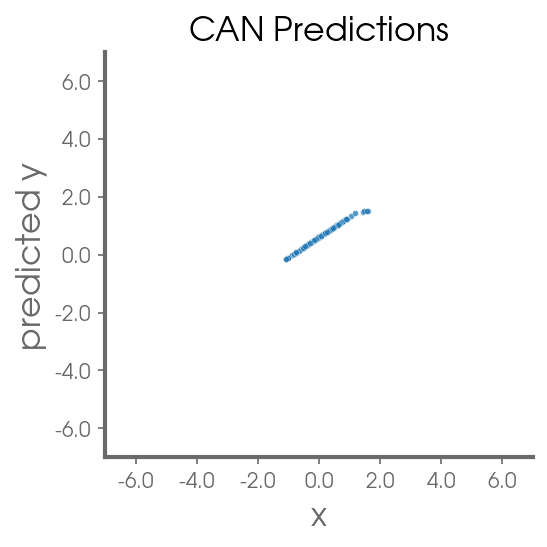

In [48]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cm = plt.cm.get_cmap('Spectral_r')
bins = np.arange(0,4.1,.05)
FS = 16

da = df[df['network_seed']==0]

if LONG_NAME.find('olsr')==0:

    bounds = 7.
    #--------------------------
    fig = plt.figure(figsize=(5*1*.75,5*.75))
    #---------------
    # actual 2D data
    ax1 = plt.subplot(1,1,1)
    sns.scatterplot(x=X_test_std.flatten(), 
                    y=y_true_test, 
#                     hue=y_pred_test[:,1],
#                     hue_norm=(0,2.),
    #                 hue_order=[0,.25,.5,.75,1.0,2.0,3.0],
                    s=8, 
                    legend=True,
                    alpha=.75,
                    color='k',
                    palette='Spectral_r')
    
    plt.xlabel('x',fontsize=FS)
    plt.ylabel('y',fontsize=FS)
    plt.xlim(-bounds,bounds)
    plt.ylim(-bounds,bounds)
    plt.title('Data',fontsize=FS)  

    array_of_xlabels = np.arange(-bounds+1,bounds+1,2)
    plt.xticks(array_of_xlabels,map(str,array_of_xlabels))
    plt.yticks(array_of_xlabels,map(str,array_of_xlabels))
    
    ax1.spines['top'].set_color('none')
    ax1.spines['right'].set_color('none')
    ax1.spines['left'].set_color('dimgrey')
    ax1.spines['bottom'].set_color('dimgrey')
    ax1.spines['left'].set_linewidth(2)
    ax1.spines['bottom'].set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig('figures/blog_figures/scatter_data_' + LONG_NAME + '_networkSeed0.png', dpi=dpiFig/2)
    plt.show()    
    
        
    #---------------
    # abstention network = .8
    fig = plt.figure(figsize=(5*1*.75,5*.75))    
    ax3 = plt.subplot(1,1,1)
#     plt.plot((-bounds,bounds),(-bounds,bounds),'--',color='tab:gray',linewidth=1.,alpha=.5)
    sns.scatterplot(x=X_test_std[i_noabstain_high,0], 
                    y=y_pred_test_abstain_high[i_noabstain_high,0], 
                    hue=None,
                    s=8, 
                    legend=False,
                    color='tab:blue',
                    alpha=.75,)

    plt.xlabel('x',fontsize=FS)
    plt.ylabel('predicted y',fontsize=FS)
    plt.xlim(-bounds,bounds)
    plt.ylim(-bounds,bounds)
    plt.title('CAN Predictions',fontsize=FS)  

    array_of_xlabels = np.arange(-bounds+1,bounds+1,2)
    plt.xticks(array_of_xlabels,map(str,array_of_xlabels))
    plt.yticks(array_of_xlabels,map(str,array_of_xlabels))

    
    #-----------------------------

    ax3.spines['top'].set_color('none')
    ax3.spines['right'].set_color('none')
    ax3.spines['left'].set_color('dimgrey')
    ax3.spines['bottom'].set_color('dimgrey')
    ax3.spines['left'].set_linewidth(2)
    ax3.spines['bottom'].set_linewidth(2)
    
    plt.tight_layout()
    plt.savefig('figures/blog_figures/scatter_predict_' + LONG_NAME + '_networkSeed0.png', dpi=dpiFig/2)
    plt.show()    


In [ ]:
raise ValueError('stop here')

In [ ]:
import pickle
from matplotlib import gridspec

history_dict = {}
spinup_epochs = 15

best_dict = {.7:23,.3:26}
letter = {.3:'(a)', .7:'(b)'}

for setpoint in (.3,.7):
        
    filename = 'history_tranquilFOOr16' + '_AbstentionLogLoss_setpoint' + str(setpoint) + '_networkSeed0_npSeed99'
    history_file = ('saved_models/' 
                    + filename
                    + '.pickle'
                   )
    # Load data (deserialize)
    with open(history_file, 'rb') as handle:
        history_dict = pickle.load(handle)
#     pprint.pprint(history_dict, width=60)
    #----------------------------------------------------------
    
    MS = 7
    colors = cmap = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
    clr_test = colors[1]
    clr_val = colors[-1]
    xticks = np.arange(0,45,5)

    fig=plt.figure(figsize=(7*.75,8*.75))
    spec = gridspec.GridSpec(ncols=1, nrows=3, height_ratios=[1, 2, 2])

    #-------------------------------
    last_epoch = best_dict[setpoint]-1
    epoch_len = len(history_dict['loss'])
    alpha_vals = np.asarray(history_dict['alpha_value'])
    alpha_vals[:spinup_epochs] = np.nan
    frac = np.asarray(history_dict['abstention_fraction'])
    val_frac = np.asarray(history_dict['val_abstention_fraction'])
    frac[:spinup_epochs] = np.nan
    val_frac[:spinup_epochs] = np.nan        
    

    ax0 = fig.add_subplot(spec[0])
    ymax_alpha = np.nanmax(alpha_vals)
    ymin_alpha = np.nanmin(alpha_vals)
    plt.axvline(x=last_epoch,linestyle='--', linewidth=1., color=colors[2])
    plt.plot(alpha_vals[:epoch_len],'.',label='alpha', markersize=MS,color='k')
    plt.title(letter[setpoint] + ' Setpoint = ' + str(setpoint) + '',fontsize=FS)
    plt.legend(loc=0,mode=None,ncol=2,fontsize=7,)
    if(setpoint==.7):
        ax0.get_legend().remove()    
    plt.xticks(xticks,labels='')
    if(setpoint==.3):
        yticks = np.around(plt.yticks()[0],1)
    else:
        yticks = np.around(plt.yticks()[0],2)
    plt.yticks(yticks,labels=yticks)    
    plt.text(last_epoch-.3, ymax_alpha*1.01, 'best epoch', color=colors[2], fontsize=7, horizontalalignment='right')
    plt.xlim(0,np.max(xticks))
    plt.ylim(ymin_alpha*.95,ymax_alpha*1.05)
    
    ax0.spines['top'].set_color('none')
    ax0.spines['right'].set_color('none')
    ax0.spines['left'].set_color('dimgrey')
    ax0.spines['bottom'].set_color('dimgrey')    

    ax1 = fig.add_subplot(spec[1])
    plt.axhline(y=setpoint,linewidth=1.,color=(.5,.5,.5,1.),linestyle='-')
    plt.fill_between(x=np.arange(0,130),y1=setpoint-.1, y2=setpoint+.1, alpha = .1, color='gray')
    plt.axvline(x=last_epoch,linestyle='--', linewidth=1., color=colors[2])
    plt.plot(frac[:epoch_len],'.',label='training', markersize=MS,color=clr_test)
    plt.plot(val_frac[:epoch_len],'.', label='validation', markersize=MS,color=clr_val)
    plt.legend(mode=None,ncol=1,title='Abstention Fraction',loc=1,fontsize=7,)
    if(setpoint==.7):
        ax1.get_legend().remove()
    plt.text(.4, setpoint+.01, 'setpoint = ' + str(np.round(setpoint,1)), color=(.5,.5,.5,1.), fontsize=7, horizontalalignment='left', verticalalignment='bottom')
    # plt.xlabel('epoch')
    plt.xticks(xticks,labels='')
    plt.ylim(0,1.)
    yticks = np.around(plt.yticks()[0],2)
    plt.yticks(yticks,labels=yticks)    
    plt.xlim(0,np.max(xticks))
    
    ax1.spines['top'].set_color('none')
    ax1.spines['right'].set_color('none')
    ax1.spines['left'].set_color('dimgrey')
    ax1.spines['bottom'].set_color('dimgrey')    


    ax2 = fig.add_subplot(spec[2])
    plt.axvline(x=last_epoch,linestyle='--', linewidth=1., color=colors[2])
    plt.plot(np.asarray(history_dict['loss'][:epoch_len]),'.',label='training', markersize=MS,color=clr_test)
    plt.plot(np.asarray(history_dict['val_loss'][:epoch_len]),'.', label='validation', markersize=MS,color=clr_val)
    plt.legend(loc=1,mode=None,ncol=1,title='Loss',fontsize=7,)
    if(setpoint==.7):
        ax2.get_legend().remove()
    plt.xlabel('epoch',fontsize=FS)
    plt.xticks(xticks,labels=xticks)
    yticks = np.around(plt.yticks()[0],3)
    plt.yticks(yticks,labels=yticks)
#     plt.ylim(0,3.)
    plt.xlim(0,np.max(xticks))
    
    ax2.spines['top'].set_color('none')
    ax2.spines['right'].set_color('none')
    ax2.spines['left'].set_color('dimgrey')
    ax2.spines['bottom'].set_color('dimgrey')
   

    # #-----------------------------
    plt.tight_layout()
    plt.savefig('figures/summary_plots/' 
                + filename
                +'.png',dpi=dpiFig/2)  
    plt.savefig('figures/final_figures/' + filename + '.png', dpi=dpiFig/2)    
#     plt.close()
    plt.show()
    

In [ ]:
import pickle
from matplotlib import gridspec

history_dict = {}
best_dict = {1:599,}
spinup_epochs = 225
setpoint = .1#.7

for run_num in (1,): #(22,16,)
        
    filename = 'history_olsr' + str(run_num) + '_AbstentionLogLoss_setpoint' + str(setpoint) + '_networkSeed0_npSeed99'
    history_file = ('saved_models/' 
                    + filename
                    + '.pickle'
                   )
    # Load data (deserialize)
    with open(history_file, 'rb') as handle:
        history_dict = pickle.load(handle)
#     pprint.pprint(history_dict, width=60)
    #----------------------------------------------------------
    
    MS = 7
    colors = cmap = palettable.cartocolors.qualitative.Vivid_10.mpl_colors
    clr_test = colors[1]
    clr_val = colors[-1]
    xticks = np.arange(0,700,50)

    fig=plt.figure(figsize=(7*.75,8*.75))
    spec = gridspec.GridSpec(ncols=1, nrows=3, height_ratios=[1, 2, 2])

    #-------------------------------
    last_epoch = best_dict[run_num]-1
    epoch_len = len(history_dict['loss'])
    alpha_vals = np.asarray(history_dict['alpha_value'])
    alpha_vals[:spinup_epochs] = np.nan
    frac = np.asarray(history_dict['abstention_fraction'])
    val_frac = np.asarray(history_dict['val_abstention_fraction'])
    frac[:spinup_epochs] = np.nan
    val_frac[:spinup_epochs] = np.nan        

    ax0 = fig.add_subplot(spec[0])
    plt.axvline(x=last_epoch,linestyle='--', linewidth=1., color=colors[2])
    plt.plot(alpha_vals[:epoch_len],'.',label='alpha', markersize=MS,color='k')
    plt.title('Fixed Alpha',fontsize=FS)
    plt.legend(loc=0,mode=None,ncol=2,fontsize=7,)
    plt.xticks(xticks,labels='')
    plt.text(last_epoch-5, .12, 'best epoch', color=colors[2], fontsize=7, horizontalalignment='right')
    plt.xlim(0,np.max(xticks))
    plt.ylim(0,.15)
    yticks = np.around(plt.yticks()[0],3)
    plt.yticks(yticks,labels=yticks)
    
    
    ax0.spines['top'].set_color('none')
    ax0.spines['right'].set_color('none')
    ax0.spines['left'].set_color('dimgrey')
    ax0.spines['bottom'].set_color('dimgrey')    

    ax1 = fig.add_subplot(spec[1])
#     plt.axhline(y=setpoint,linewidth=1.,color=(.5,.5,.5,1.),linestyle='-')
#     plt.fill_between(x=np.arange(0,700),y1=setpoint-.1, y2=setpoint+.1, alpha = .1, color='gray')
    plt.axvline(x=last_epoch,linestyle='--', linewidth=1., color=colors[2])
    plt.plot(frac[:epoch_len],'.',label='training', markersize=MS,color=clr_test)
    plt.plot(val_frac[:epoch_len],'.', label='validation', markersize=MS,color=clr_val)
    plt.legend(mode=None,ncol=1,title='Abstention Fraction',loc=3,fontsize=7,)
#     plt.text(10, setpoint+.01, 'setpoint = ' + str(np.round(setpoint,1)), color=(.5,.5,.5,1.), fontsize=7, horizontalalignment='left', verticalalignment='bottom')
    # plt.xlabel('epoch')
    plt.xticks(xticks,labels='')
    plt.ylim(0,1.)
    plt.xlim(0,np.max(xticks))
    yticks = np.around(plt.yticks()[0],3)
    plt.yticks(yticks,labels=yticks)
    
    
    ax1.spines['top'].set_color('none')
    ax1.spines['right'].set_color('none')
    ax1.spines['left'].set_color('dimgrey')
    ax1.spines['bottom'].set_color('dimgrey')    


    ax2 = fig.add_subplot(spec[2])
    plt.axvline(x=last_epoch,linestyle='--', linewidth=1., color=colors[2])
    plt.plot(np.asarray(history_dict['loss'][:epoch_len]),'.',label='training', markersize=MS,color=clr_test)
    plt.plot(np.asarray(history_dict['val_loss'][:epoch_len]),'.', label='validation', markersize=MS,color=clr_val)
    plt.legend(loc=2,mode=None,ncol=1,title='Loss',fontsize=7,)
    plt.xlabel('epoch',fontsize=FS)
    plt.xticks(xticks,labels=xticks)
    plt.ylim(0,2.75)
    plt.xlim(0,np.max(xticks))
    yticks = np.around(plt.yticks()[0],3)
    plt.yticks(yticks,labels=yticks)
    
    
    ax2.spines['top'].set_color('none')
    ax2.spines['right'].set_color('none')
    ax2.spines['left'].set_color('dimgrey')
    ax2.spines['bottom'].set_color('dimgrey')
    

    # #-----------------------------
    plt.tight_layout()
    plt.savefig('figures/summary_plots/' 
                + filename
                +'.png',dpi=dpiFig/2)  
    plt.savefig('figures/final_figures/' + filename + '.png', dpi=dpiFig/2)        
#     plt.close()
    plt.show()
    